In [94]:
!pip install matplotlib

In [95]:
import numpy as np
import cupy as cp
from matplotlib import pyplot, cm
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import pylab as p

In [96]:
plt.interactive(True)


nx = 41
ny = 41
nit = 50
c = 1
dx = 2 / (nx - 1)
dy = 2 / (ny - 1)
x = np.linspace(0, 2, nx)
y = np.linspace(0, 2, ny)
X, Y = np.meshgrid(x, y)

rho = 1
nu = .1
dt = .001

u = np.zeros((ny, nx))
v = np.zeros((ny, nx))
p = np.zeros((ny, nx)) 
b = np.zeros((ny, nx))

In [97]:
meshscale = 20
nx = 41*meshscale
ny = 41*meshscale
nt = 10
nit = 50 * meshscale
c = 1
dx = 2 / (nx - 1)
dy = 2 / (ny - 1)
x = np.linspace(0, 2, nx, dtype = np.float64)
y = np.linspace(0, 2, ny, dtype = np.float64)
X, Y = np.meshgrid(x, y)

rho = 1
nu = .1
dt = .001 / meshscale

u = np.zeros((ny, nx), dtype = np.float64)
v = np.zeros((ny, nx), dtype = np.float64)
p = np.zeros((ny, nx), dtype = np.float64)
b = np.zeros((ny, nx), dtype = np.float64)


In [98]:
# The pressure Poisson equation that's written above can be hard to write out without typos. 
# The function build_up_b below represents the contents of the square brackets, 
# so that the entirety of the PPE is slightly more manageable.

def build_up_b(b, rho, dt, u, v, dx, dy):
    
    b[1:-1, 1:-1] = (rho * (1 / dt * 
                    ((u[1:-1, 2:] - u[1:-1, 0:-2]) / 
                     (2 * dx) + (v[2:, 1:-1] - v[0:-2, 1:-1]) / (2 * dy)) -
                    ((u[1:-1, 2:] - u[1:-1, 0:-2]) / (2 * dx))**2 -
                      2 * ((u[2:, 1:-1] - u[0:-2, 1:-1]) / (2 * dy) *
                           (v[1:-1, 2:] - v[1:-1, 0:-2]) / (2 * dx))-
                          ((v[2:, 1:-1] - v[0:-2, 1:-1]) / (2 * dy))**2))

    return b


In [99]:
def pressure_poisson(p, dx, dy, b):
    pn = np.empty_like(p)
    pn = p.copy()
    
    for q in range(nit):
        pn = p.copy()
        p[1:-1, 1:-1] = (((pn[1:-1, 2:] + pn[1:-1, 0:-2]) * dy**2 + 
                          (pn[2:, 1:-1] + pn[0:-2, 1:-1]) * dx**2) /
                          (2 * (dx**2 + dy**2)) -
                          dx**2 * dy**2 / (2 * (dx**2 + dy**2)) * 
                          b[1:-1,1:-1])
        p[:, -1] = p[:, -2] # dp/dx = 0 at x = 2
        p[0, :] = p[1, :]   # dp/dy = 0 at y = 0
        p[:, 0] = p[:, 1]   # dp/dx = 0 at x = 0
        p[-1, :] = 0        # p = 0 at y = 2
        
    return p

In [100]:
# Finally, the rest of the cavity flow equations are wrapped inside the function cavity_flow, allowing us to easily plot the results of the cavity flow solver for different lengths of time.

def cavity_flow(nt, u, v, dt, dx, dy, p, rho, nu):
    print('caviry dlow called: nt=',nt)
    un = np.empty_like(u)
    vn = np.empty_like(v)
    b = np.zeros((ny, nx))
    
    for n in range(nt):
        un = u.copy()
        vn = v.copy()
        
        b = build_up_b(b, rho, dt, u, v, dx, dy)
        p = pressure_poisson(p, dx, dy, b)
        
        u[1:-1, 1:-1] = (un[1:-1, 1:-1]-
                         un[1:-1, 1:-1] * dt / dx *
                        (un[1:-1, 1:-1] - un[1:-1, 0:-2]) -
                         vn[1:-1, 1:-1] * dt / dy *
                        (un[1:-1, 1:-1] - un[0:-2, 1:-1]) -
                         dt / (2 * rho * dx) * (p[1:-1, 2:] - p[1:-1, 0:-2]) +
                         nu * (dt / dx**2 *
                        (un[1:-1, 2:] - 2 * un[1:-1, 1:-1] + un[1:-1, 0:-2]) +
                         dt / dy**2 *
                        (un[2:, 1:-1] - 2 * un[1:-1, 1:-1] + un[0:-2, 1:-1])))

        v[1:-1,1:-1] = (vn[1:-1, 1:-1] -
                        un[1:-1, 1:-1] * dt / dx *
                       (vn[1:-1, 1:-1] - vn[1:-1, 0:-2]) -
                        vn[1:-1, 1:-1] * dt / dy *
                       (vn[1:-1, 1:-1] - vn[0:-2, 1:-1]) -
                        dt / (2 * rho * dy) * (p[2:, 1:-1] - p[0:-2, 1:-1]) +
                        nu * (dt / dx**2 *
                       (vn[1:-1, 2:] - 2 * vn[1:-1, 1:-1] + vn[1:-1, 0:-2]) +
                        dt / dy**2 *
                       (vn[2:, 1:-1] - 2 * vn[1:-1, 1:-1] + vn[0:-2, 1:-1])))

        u[0, :]  = 0
        u[:, 0]  = 0
        u[:, -1] = 0
        u[-1, :] = 1    # set velocity on cavity lid equal to 1
        v[0, :]  = 0
        v[-1, :] = 0
        v[:, 0]  = 0
        v[:, -1] = 0
        
        
    return u, v, p

caviry dlow called: nt= 100


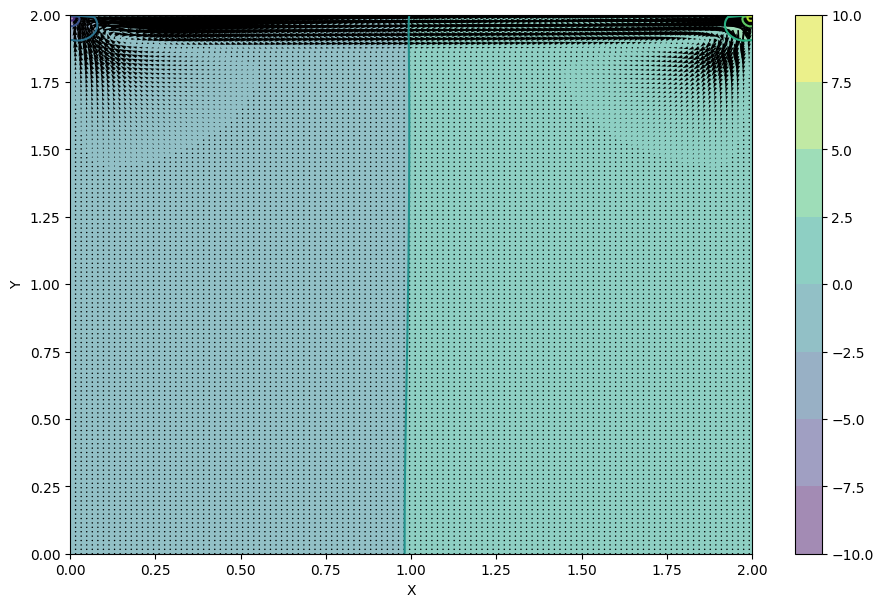

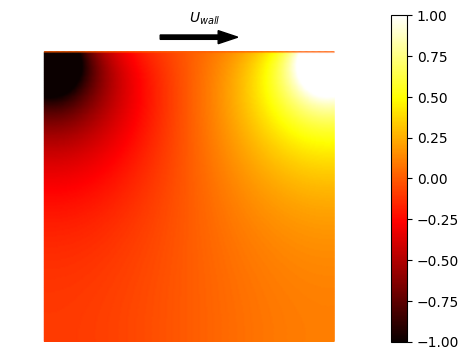

In [80]:
# Let's start with nt = 100 and see what the solver gives us:

u = np.zeros((ny, nx))
v = np.zeros((ny, nx))
p = np.zeros((ny, nx))
b = np.zeros((ny, nx))
nt = 100


u, v, p = cavity_flow(nt, u, v, dt, dx, dy, p, rho, nu)

fig = pyplot.figure(figsize=(11,7), dpi=100)
# plotting the pressure field as a contour
pyplot.contourf(X, Y, p, alpha=0.5, cmap=cm.viridis)  
pyplot.colorbar()
# plotting the pressure field outlines
pyplot.contour(X, Y, p, cmap=cm.viridis)  
plt.savefig('p_NS.png',bbox_inches='tight')
# plotting velocity field
pyplot.quiver(X[::2, ::2], Y[::2, ::2], u[::2, ::2], v[::2, ::2]) 
pyplot.xlabel('X')
pyplot.ylabel('Y');
plt.savefig('vect_NS.png',bbox_inches='tight')


########################################## iso u
fig1,ax1 = plt.subplots()
plt.subplots_adjust(left=0.20,bottom=0.20)
im=plt.pcolormesh(X,Y,p, vmin=-1,vmax=1,cmap=plt.get_cmap('hot'),shading='gouraud')
fig1.colorbar(im)
plt.arrow(x=0.8, y=2.1, dx=0.4, dy=0, width=.03,facecolor='black')
plt.text(1,2.2,'$U_{wall}$')
plt.axis('equal')
# plt.colorbar()
plt.axis('off')
plt.box(on=None)
plt.savefig('u_NS_iso.png')


# Profile 

In [102]:
import cProfile, pstats

u = np.zeros((ny, nx))
v = np.zeros((ny, nx))
p = np.zeros((ny, nx))
b = np.zeros((ny, nx))
nt = 100

profiler = cProfile.Profile()
profiler.enable()
u, v, p = cavity_flow(nt, u, v, dt, dx, dy, p, rho, nu)
profiler.disable()
stats = pstats.Stats(profiler).sort_stats('tottime')
stats.print_stats(10)

caviry dlow called: nt= 100


/tmp/ipykernel_2392/372520547.py:10: RuntimeWarning: overflow encountered in square
  ((u[1:-1, 2:] - u[1:-1, 0:-2]) / (2 * dx))**2 -
/tmp/ipykernel_2392/372520547.py:11: RuntimeWarning: overflow encountered in multiply
  2 * ((u[2:, 1:-1] - u[0:-2, 1:-1]) / (2 * dy) *
/tmp/ipykernel_2392/372520547.py:11: RuntimeWarning: overflow encountered in divide
  2 * ((u[2:, 1:-1] - u[0:-2, 1:-1]) / (2 * dy) *
/tmp/ipykernel_2392/372520547.py:7: RuntimeWarning: overflow encountered in subtract
  b[1:-1, 1:-1] = (rho * (1 / dt *
/tmp/ipykernel_2392/372520547.py:7: RuntimeWarning: invalid value encountered in subtract
  b[1:-1, 1:-1] = (rho * (1 / dt *
/tmp/ipykernel_2392/372520547.py:13: RuntimeWarning: overflow encountered in square
  ((v[2:, 1:-1] - v[0:-2, 1:-1]) / (2 * dy))**2))
/tmp/ipykernel_2392/1907953053.py:17: RuntimeWarning: overflow encountered in multiply
  un[1:-1, 1:-1] * dt / dx *
/tmp/ipykernel_2392/1907953053.py:19: RuntimeWarning: overflow encountered in multiply
  vn[1:-1, 1:-

         100955 function calls in 468.685 seconds

   Ordered by: internal time
   List reduced from 49 to 10 due to restriction <10>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
      100  423.937    4.239  464.840    4.648 /tmp/ipykernel_2392/905643135.py:1(pressure_poisson)
   100300   41.009    0.000   41.009    0.000 {method 'copy' of 'numpy.ndarray' objects}
        1    2.712    2.712  468.685  468.685 /tmp/ipykernel_2392/1907953053.py:3(cavity_flow)
      100    1.026    0.010    1.026    0.010 /tmp/ipykernel_2392/372520547.py:5(build_up_b)
        1    0.000    0.000    0.000    0.000 {built-in method numpy.zeros}
       14    0.000    0.000    0.000    0.000 /usr/lib/python3.10/warnings.py:35(_formatwarnmsg_impl)
       18    0.000    0.000    0.000    0.000 /usr/local/lib/python3.10/dist-packages/ipykernel/iostream.py:626(write)
        2    0.000    0.000    0.000    0.000 {built-in method builtins.compile}
        3    0.000    0.000    0.000   

In [82]:

# Let's start with nt = 100 and see what the solver gives us:
u = np.zeros((ny, nx))
v = np.zeros((ny, nx))
p = np.zeros((ny, nx))
b = np.zeros((ny, nx))
nt = 100

In [83]:
%%timeit
cavity_flow(nt, u, v, dt, dx, dy, p, rho, nu)

caviry dlow called: nt= 100
caviry dlow called: nt= 100
caviry dlow called: nt= 100
caviry dlow called: nt= 100
caviry dlow called: nt= 100
caviry dlow called: nt= 100
caviry dlow called: nt= 100
caviry dlow called: nt= 100
9.2 s ± 943 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


# CUPY version

In [90]:
import cupy as np
# Let's start with nt = 100 and see what the solver gives us:
u = np.zeros((ny, nx))
v = np.zeros((ny, nx))
p = np.zeros((ny, nx))
b = np.zeros((ny, nx))
nt = 100

In [91]:
%%timeit
cavity_flow(nt, u, v, dt, dx, dy, p, rho, nu)

caviry dlow called: nt= 100
caviry dlow called: nt= 100
caviry dlow called: nt= 100
caviry dlow called: nt= 100
caviry dlow called: nt= 100
caviry dlow called: nt= 100
caviry dlow called: nt= 100
caviry dlow called: nt= 100
1min 50s ± 1.32 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


caviry dlow called: nt= 100


/usr/local/lib/python3.10/dist-packages/matplotlib/quiver.py:645: RuntimeWarning: divide by zero encountered in scalar divide
  length = a * (widthu_per_lenu / (self.scale * self.width))
/usr/local/lib/python3.10/dist-packages/matplotlib/quiver.py:645: RuntimeWarning: invalid value encountered in multiply
  length = a * (widthu_per_lenu / (self.scale * self.width))


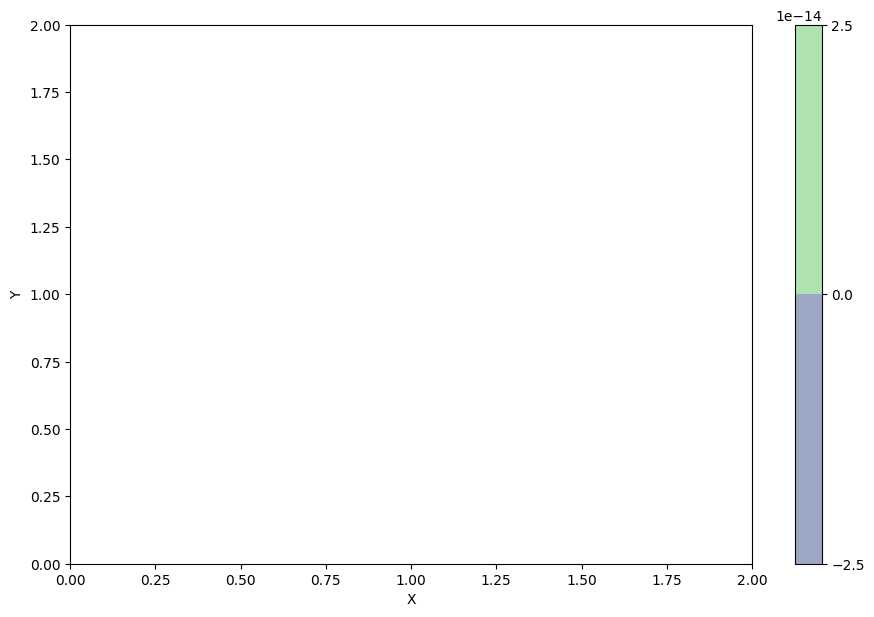

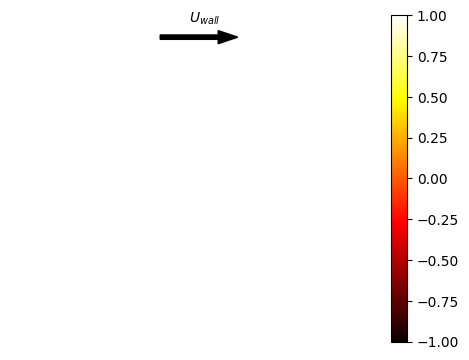

In [92]:
# Let's start with nt = 100 and see what the solver gives us:
u = np.zeros((ny, nx))
v = np.zeros((ny, nx))
p = np.zeros((ny, nx))
b = np.zeros((ny, nx))
nt = 100

u, v, p = cavity_flow(nt, u, v, dt, dx, dy, p, rho, nu)


fig = pyplot.figure(figsize=(11,7), dpi=100)
# plotting the pressure field as a contour
pyplot.contourf(cp.asnumpy(X), cp.asnumpy(Y), cp.asnumpy(p), alpha=0.5, cmap=cm.viridis)  
pyplot.colorbar()
# plotting the pressure field outlines
pyplot.contour(cp.asnumpy(X), cp.asnumpy(Y), cp.asnumpy(p), cmap=cm.viridis)  
plt.savefig('p_NS.png',bbox_inches='tight')
# plotting velocity field
pyplot.quiver(cp.asnumpy(X[::2, ::2]), cp.asnumpy(Y[::2, ::2]), cp.asnumpy(u[::2, ::2]), cp.asnumpy(v[::2, ::2])) 
pyplot.xlabel('X')
pyplot.ylabel('Y');
plt.savefig('vect_NS.png',bbox_inches='tight')


########################################## iso u
fig1,ax1 = plt.subplots()
plt.subplots_adjust(left=0.20,bottom=0.20)
im=plt.pcolormesh(cp.asnumpy(X), cp.asnumpy(Y), cp.asnumpy(p), vmin=-1,vmax=1,cmap=plt.get_cmap('hot'),shading='gouraud')
fig1.colorbar(im)
plt.arrow(x=0.8, y=2.1, dx=0.4, dy=0, width=.03,facecolor='black')
plt.text(1,2.2,'$U_{wall}$')
plt.axis('equal')
# plt.colorbar()
plt.axis('off')
plt.box(on=None)
plt.savefig('u_NS_iso.png')

In [93]:
import cProfile, pstats

profiler = cProfile.Profile()
profiler.enable()
u, v, p = cavity_flow(nt, u, v, dt, dx, dy, p, rho, nu)
profiler.disable()
stats = pstats.Stats(profiler).sort_stats('tottime')
stats.print_stats(10)

caviry dlow called: nt= 100
         1906408 function calls in 115.004 seconds

   Ordered by: internal time
   List reduced from 51 to 10 due to restriction <10>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
      100  105.906    1.059  114.396    1.144 /tmp/ipykernel_2392/905643135.py:1(pressure_poisson)
   100300    6.677    0.000    6.677    0.000 {method 'copy' of 'cupy._core.core._ndarray_base' objects}
   700902    1.065    0.000    1.416    0.000 /usr/local/lib/python3.10/dist-packages/numpy/core/numeric.py:1855(isscalar)
   403100    0.410    0.000    0.410    0.000 /usr/local/lib/python3.10/dist-packages/numpy/core/multiarray.py:618(min_scalar_type)
        1    0.397    0.397  115.003  115.003 /tmp/ipykernel_2392/1907953053.py:3(cavity_flow)
   701008    0.351    0.000    0.352    0.000 {built-in method builtins.isinstance}
      100    0.190    0.002    0.191    0.002 /tmp/ipykernel_2392/372520547.py:5(build_up_b)
      102    0.003    0.000    0.